In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
import json
acc_score = od()

In [2]:
def get_entropy_from_culling_factor(c):
    S = od({1: 0})
    for E in range(0, -len(c) + 2, -1):
        S[E] = S[E + 1] + np.log(1 - c[E + 1])
    for E in range(0, -len(c) + 2, -1):
        S[E] += np.log(c[E])
    return S

In [3]:
d = [
    {
        "q": 4,
        "L": 6,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    },
    {
        "q": 4,
        "L": 8,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    },
    {
        "q": 4,
        "L": 12,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    },
    {
        "q": 4,
        "L": 16,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    },
    {
        "q": 4,
        "L": 18,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    },
    {
        "q": 4,
        "L": 24,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    }
]
d = [
    {
        "q": 4,
        "L": 4,
        "R" : 262144,
        "nSteps" : 50,
        "seed" : 0,
    }
]
for i, parameters in enumerate(d):
    
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    N=L*L;
    name = "./datasets/2DHexPotts_q{}_N{}_R{}_nSteps{}_run{}X.txt".format(q, N, R, nSteps, seed)
    culling_factor = od()
    culling_factor[1] = 0
    culling_factor[0] = 0
    print(N, R, nSteps)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    d[i]["culling_factor"] = culling_factor
    d[i]["S"] = get_entropy_from_culling_factor(culling_factor)
    

16 262144 50


FileNotFoundError: [Errno 2] No such file or directory: './datasets/2DHexPotts_q4_N16_R262144_nSteps50_run0X.txt'

No handles with labels found to put in legend.


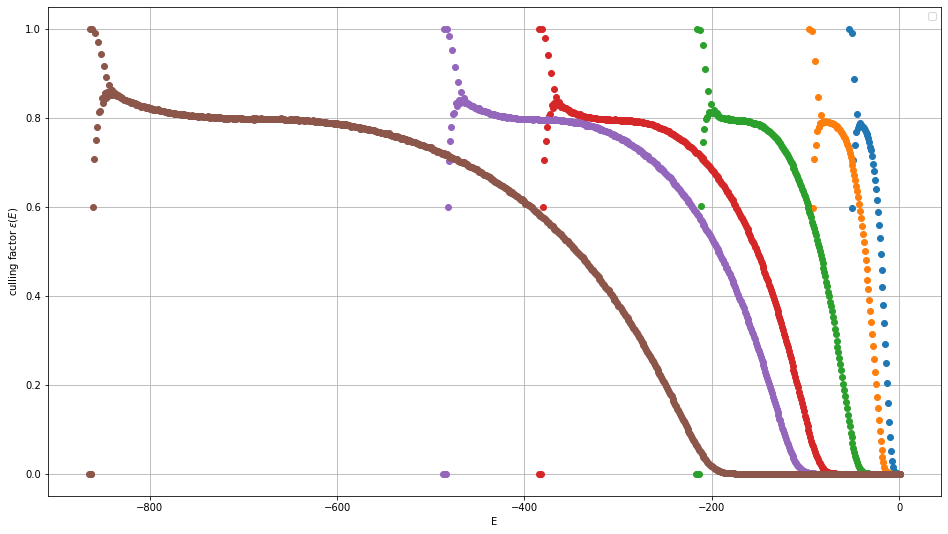

In [4]:
plt.figure(figsize=(16, 9))
for parameters in d:
    plt.plot([E for E in parameters["culling_factor"]], [c for E, c in parameters["culling_factor"].items()], 'o')

plt.ylabel("culling factor $\epsilon(E)$")
plt.xlabel("E")
#plt.yscale("log")
plt.legend()
plt.grid()
#plt.savefig("2.png")

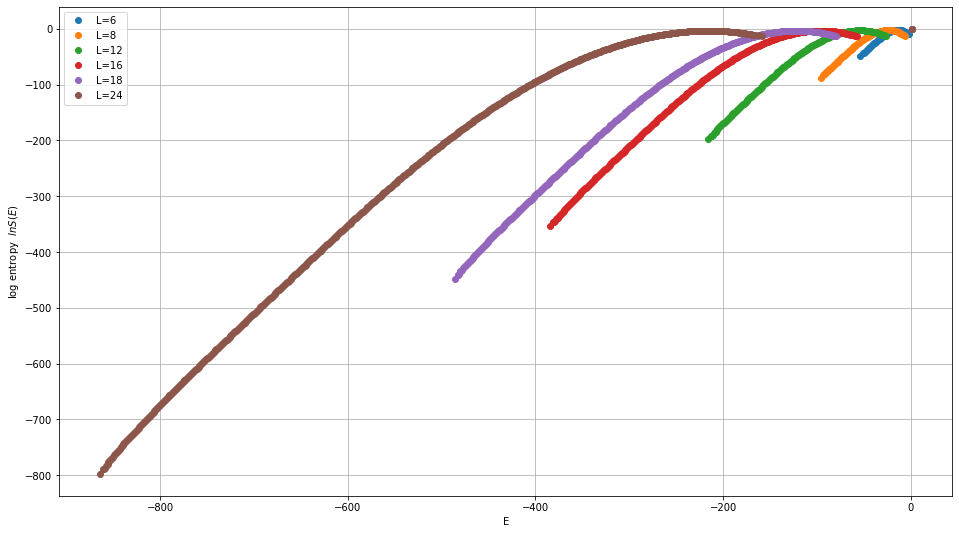

In [5]:
plt.figure(figsize=(16, 9))
for parameters in d:
    plt.plot([E for E in parameters["S"]], [S for E, S in parameters["S"].items()], 'o', label="L={}".format(parameters["L"]))

plt.ylabel("log entropy  $ln S(E)$")
plt.xlabel("E")
plt.legend()
plt.grid()

In [6]:
with open('2dHexPottsEntropy-Machta.txt', 'w') as outfile:
    json.dump(d, outfile)

In [7]:
with open('2dHexPottsEntropy-Machta.txt') as json_file:
    data = json.load(json_file)

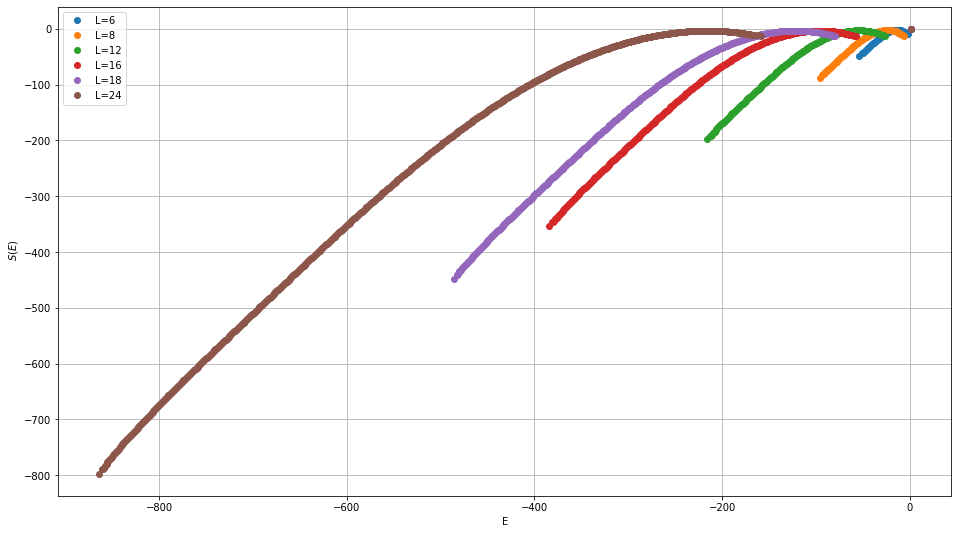

In [14]:
plt.figure(figsize=(16, 9))
for parameters in data:
    plt.plot([float(E) for E in parameters["S"]], [S for E, S in parameters["S"].items()], 'o',
            label="L={}".format(parameters["L"]))

plt.ylabel(" $S(E)$")
plt.xlabel("E")
plt.legend()
plt.grid()

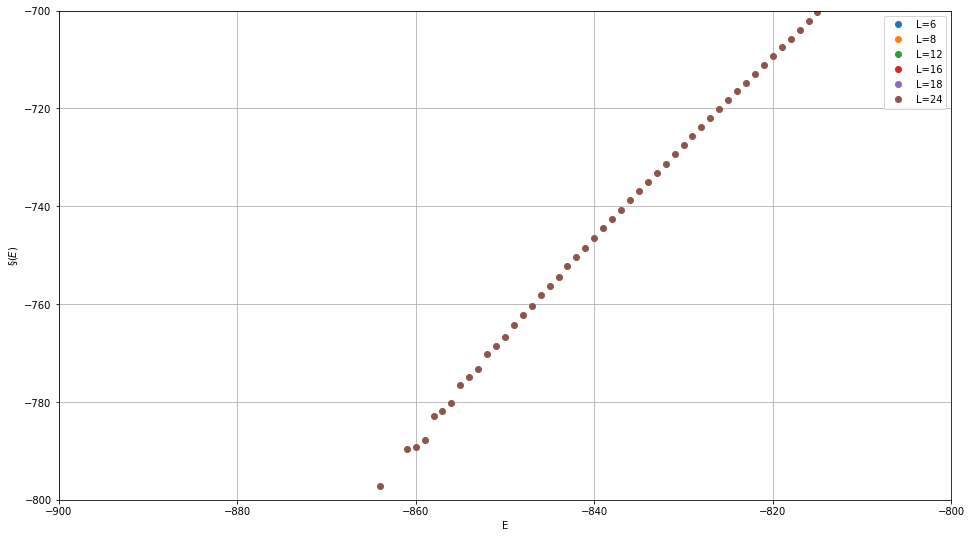

In [15]:
plt.figure(figsize=(16, 9))
for parameters in data:
    plt.plot([float(E) for E in parameters["S"]], [S for E, S in parameters["S"].items()], 'o',
            label="L={}".format(parameters["L"]))

plt.ylabel("$\S(E)$")
plt.xlabel("E")
plt.xlim([-900, -800])
plt.ylim([-800, -700])
plt.legend()
plt.grid()

R movement

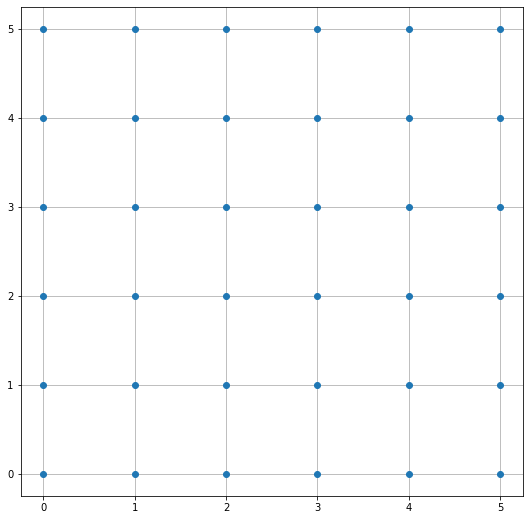

In [13]:
def get_coords(i, L):
    return i % L, i // L
def sign(x):
    if x > 0:
        return 1
    else:
        return -1
def plot_line(pair, L):
    i, j = pair
    ix, iy = get_coords(i, L)
    jx, jy = get_coords(j, L)
    if ix in (0, L - 1) and jx in (0, L - 1) and ix != jx:
        dx = ix - jx
        plt.plot([ix, ix+sign(dx)/2], [iy, iy], c='r')
        plt.plot([jx, jx-sign(dx)/2], [jy, jy], c='r')
    elif iy in (0, L - 1) and jy in (0, L - 1) and iy != jy:
        dy = iy - jy
        plt.plot([ix, ix], [iy, iy+sign(dy)/2], c='r')
        plt.plot([jx, jx], [jy, jy-sign(dy)/2], c='r')
    else:
        plt.plot([ix, jx], [iy, jy], c='g')

plt.figure(figsize=(9, 9))
plt.plot([i for i in range(0, L) for j in range(0, L)], [j for i in range(0, L) for j in range(0, L)], 'o')
for pair in data:
    plot_line(pair, L)
plt.grid()
plt.show()